# Load in the neccessary libraries

In [1]:
library(GGally) 
library(ggplot2) 
library(infer)
library(corrplot) 
library(reshape2) 
library(gridExtra)
library(broom)
library(performance)
library(glmbb)
library(cowplot)
library(tidyverse)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

corrplot 0.92 loaded

Warning message:
“package ‘broom’ was built under R version 4.3.3”
Warning message:
“package ‘performance’ was built under R version 4.3.3”
── Attaching core tidyverse packages ───────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()   masks gridExtra::combine()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Oveview of the data and goal of project 


## 1. Dataset Overview:


The **Employee Retention data set** "https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset?resource=download" contains information about employees in various cities. 

Here's a quick summary of this data set:

**Summary:**
- Number of observations: 4654
- Number of features

**Features:**
- `education`: the degree which each employee obtain.
- `JoiningYear`: year at which the employee join the company.
- `City`: The location or city where each employee is based or works.
- `PaymentTier`: categorization of employees into different salary tiers.
- `Age`: the age of each employee, providing demographic insights.
- `Gender`: gender identity of employees, promoting diversity analysis.
- `EverBenched`: Indicates if an employee has ever been temporarily without assigned work.
- `ExperienceInCurrentDomain`: the number of years of experience employees have in their current field.
- `LeaveOrNot`: whether the employee left the company or not.

**Background:**

The data have been collected from company's HR department in 2018 which provide valuable insights into the workforce while maintaining employees privacy rights.

## 2. Objective:

The goal is to predict the likelihood of an employee leaving the company based on various factors using statisticall modelling for prediction to understand which factors are most influential in this decision.

There are many features that can be used to predict `LeaveOrNot`. However, some covariates could be heavily correlated such as `PaymentTier` and `ExperienceIncurrentDomain`. We will try to address that by visuallizing the relationships between our variables. Glacing at data frame, some good predictors candidates could be: `education`, `PaymentTier`,`Age`, and `EverBenched`.  We beg the question: 

### <center>How does education, payment tier, age, and benched status affects employee's retention?</center>

## 3. Exploratory Data Analysis and Visualization

#### Let's first take a look at our dataset

In [2]:
data <- read_csv("data/Employee.csv")
head(data) 

Rows: 4653 Columns: 9
── Column specification ─────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Education, City, Gender, EverBenched
dbl (5): JoiningYear, PaymentTier, Age, ExperienceInCurrentDomain, LeaveOrNot

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,Male,No,0,0
Bachelors,2013,Pune,1,28,Female,No,3,1
Bachelors,2014,New Delhi,3,38,Female,No,2,0
Masters,2016,Bangalore,3,27,Male,No,5,1
Masters,2017,Pune,3,24,Male,Yes,2,1
Bachelors,2016,Bangalore,3,22,Male,No,0,0


#### There are a few problems with our data frame:
- `Gender`, `EverBenched` variable type is character while they should be factor variables
- Unknown `NA` observation might appear in our dataset

Wrangling the data frame by converting the variables and dropping the NAs observations can address our issues!

For the purpose of calculating the correlation between each variable, we will mutate `Gender` to 0 if it's male, 1 if it's female; `EverBenched`to 0 if the employee hasn't been benched, 1 if the empoyee has been benched.

In [3]:
data$City <- as.factor(data$City) 
data$Gender <- ifelse(data$Gender == "Male",0 , 1)
data$EverBenched <- ifelse(data$EverBenched == "No", 0 , 1)

data <- data %>%
    drop_na()

head(data)


Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bachelors,2017,Bangalore,3,34,0,0,0,0
Bachelors,2013,Pune,1,28,1,0,3,1
Bachelors,2014,New Delhi,3,38,1,0,2,0
Masters,2016,Bangalore,3,27,0,0,5,1
Masters,2017,Pune,3,24,0,1,2,1
Bachelors,2016,Bangalore,3,22,0,0,0,0


### Visualizing:

Visuallizing the data can help us understand the correlation between each variables much better. 

#### Correlation Heatmap:

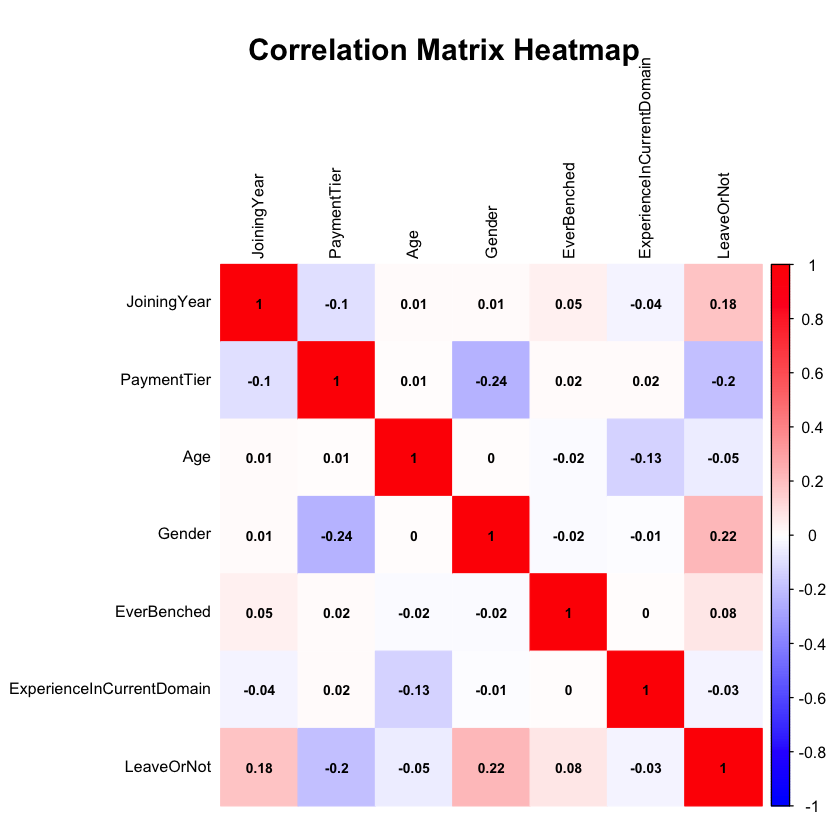

In [4]:
# Selecting numerical columns for correlation analysis
numeric_data <- data[, sapply(data, is.numeric)]
constant_columns <- sapply(numeric_data, function(col) sd(col) == 0)
filtered_data <- numeric_data[, !constant_columns]

# Compute the correlation matrix
correlation_matrix <- cor(filtered_data, use = "complete.obs")

                           
# Plot correlation heatmap
corrplot(correlation_matrix, method="color", col=colorRampPalette(c("blue", "white", "red"))(200), 
         tl.col="black", tl.cex=0.8, number.cex=0.7, addCoef.col="black",
                 mar=c(0, 0, 1, 0))
title(main="Correlation Matrix Heatmap", cex.main=1.5, font.main=2)


**Interpretation:**
- Surprisingly, variables that seems to be associated like `PaymentTier` and `ExperienceInCurrentDomain` has a low correlation coefficient.
- The variables that seems to have a high correlation to our variable of interest `LeaveOrNot` seems to be `Gender` and `JoiningYear` but that has to be inspected further with hypothesis tests and standard errors.

### Relationship of each covariate vs retetion

Let's take alook at the relationship of each covariate with retention likelyhood (`LeaveOrNot`)

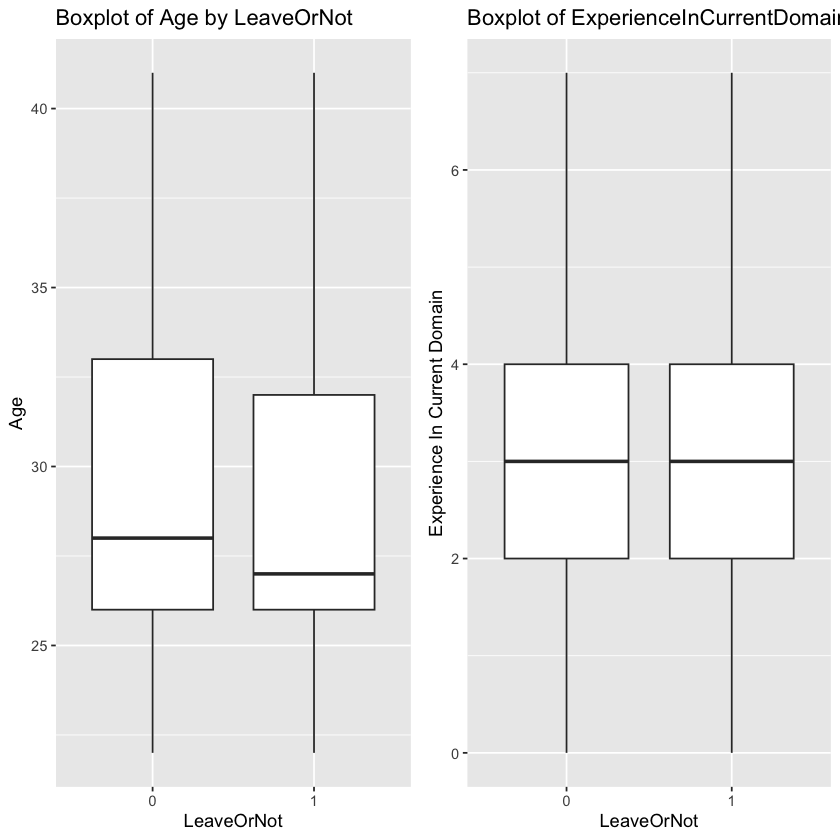

In [5]:
# Boxplot for Age
p1 <- ggplot(data, aes(x=factor(LeaveOrNot), y=Age)) +
  geom_boxplot() +
  labs(title="Boxplot of Age by LeaveOrNot", x="LeaveOrNot", y="Age")

# Boxplot for ExperienceInCurrentDomain
p2 <- ggplot(data, aes(x=factor(LeaveOrNot), y=ExperienceInCurrentDomain)) +
  geom_boxplot() +
  labs(title="Boxplot of ExperienceInCurrentDomain by LeaveOrNot", x="LeaveOrNot", y="Experience In Current Domain")

# Arrange numerical plots in a grid
grid.arrange(p1, p2, ncol=2)


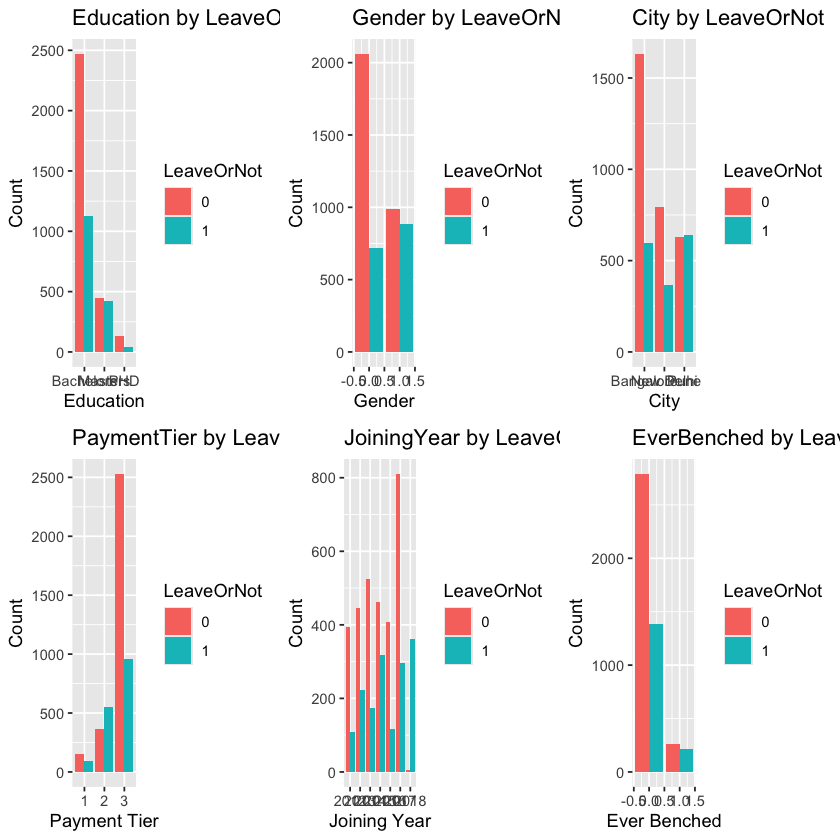

In [17]:
# Countplot for Education
p3 <- ggplot(data, aes(x=Education, fill=factor(LeaveOrNot))) +
  geom_bar(position="dodge") +
  labs(title="Education by LeaveOrNot", x="Education", y="Count", fill="LeaveOrNot")

# Countplot for Gender
p4 <- ggplot(data, aes(x=Gender, fill=factor(LeaveOrNot))) +
  geom_bar(position="dodge") +
  labs(title="Gender by LeaveOrNot", x="Gender", y="Count", fill="LeaveOrNot")

# Countplot for City
p5 <- ggplot(data, aes(x=City, fill=factor(LeaveOrNot))) +
  geom_bar(position="dodge") +
  labs(title="City by LeaveOrNot", x="City", y="Count", fill="LeaveOrNot")

# Countplot for PaymentTier
p6 <- ggplot(data, aes(x=factor(PaymentTier), fill=factor(LeaveOrNot))) +
  geom_bar(position="dodge") +
  labs(title="PaymentTier by LeaveOrNot", x="Payment Tier", y="Count", fill="LeaveOrNot")

# Countplot for JoiningYear
p7 <- ggplot(data, aes(x=factor(JoiningYear), fill=factor(LeaveOrNot))) +
  geom_bar(position="dodge") +
  labs(title="JoiningYear by LeaveOrNot", x="Joining Year", y="Count", fill="LeaveOrNot")

# Countplot for EverBenched
p8 <- ggplot(data, aes(x=EverBenched, fill=factor(LeaveOrNot))) +
  geom_bar(position="dodge") +
  labs(title="EverBenched by LeaveOrNot", x="Ever Benched", y="Count", fill="LeaveOrNot") 


# Arrange categorical plots in a grid

grid.arrange(p3, p4, p5, p6, p7, p8,  ncol = 3, widths =)


## 4. Methods and Plans

Based on the visualizations, there are some variables which might be good candidates for our logistic regression model. Here's a summary quick interpretation of the plots:

1. `Age`:
The box plot of `Age` by `LeaveOrNot` shows some variation between the 2 groups. Though it might not be highly significant, it can help us understand other relationship and behaviour of our model in later estimations.
  
2. `Gender`
The countplot for Gender shows a noticeable difference between male and female empoyees (1 being female and 0 being male). This suggests that gender could be an important factor.
  
4. `City`
The distribution of employees who left and who doesn't differs significantly between cities, indicating that location also play a role in the decision to leave
  
5. `PaymentTier`
The countploy for Payment Tier shows differentiation in distributions between the 3 tiers. This could be a significant predictor.
  
6. `EverBenched`
The countplot for `EverBenched` shows a noteable difference between the groups which also suggests that this could be a strong predictor. 

**Proposed Model: Logistic Regression**

1. **Binary Outcome:** Logistic regression is appropriate for binary response variables which would allow us to estimate the probability of employee retention based on our covariates.

2. **Interpretability:** The coefficients from logistic (logit) provide insights into the odds of the outcome occuring, making it easy to interpret.

3. **Handling Non-linearity:** By using a logistic model, it can model non-linear relationships between the predictors and the probability of the binary outcome.

**Assumptions:**

1. **Linearity of Logits:** The relationship between our covariates and the logit of `LeaveOrNot` should reflect a linear relationship.

 
2. **Independence:** Observations should be independent of each other.


3. **Multicollinearity** Independent variables should not be heavily correlated.


**Potential Limitations:**

- The model assumes a linear relationship between the logit of the repsonse variable and the predictor variables which might or might not be the case here. Further analysis is needed.


- Logistic regression can be sensitive to outliers, which can influence the model's preformance.

- The appropriate number of predictors to achieve quality results.

- If the model has too many predictors, interpretation of the coefficients can be a challenge.

These issues will be addressed and overcome when fitting the model and estimating the coefficients with more detailed analysis.